In [1]:
#This should be the final script do work with
#Use the directory /data/results/prajna/active_directory_results/new_data_collected/hash_data_combined_new/
#filtered_merged_logs.csv - has the fixed dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from Levenshtein import distance as levenshtein_distance
from datetime import timedelta
import numpy as np

In [3]:
# Load cleaned dataset
df = pd.read_csv("/data/results/prajna/active_directory_results/new_data_collected/hash_data_combined_new/filtered_merged_logs.csv", index_col=0)
df

#If you want to run the original code

# merged_file = "/data/results/prajna/active_directory_results/new_data_collected/hash_data_combined_new/merged_logs.csv"
# df = pd.read_csv(merged_file, header=None)

# df.columns = ["Date and Time", "Source", "Event ID", "Task Category", "Information", "Hash","Machine","LogType","Level"]

# #drop the first row
# df = df.drop(index=0).reset_index(drop=True)

# # Convert Date and Time to datetime, allowing errors
# df['Date and Time'] = pd.to_datetime(df['Date and Time'], errors='coerce')

# # Convert Level to datetime (for missing timestamps)
# df['Level'] = pd.to_datetime(df['Level'], errors='coerce')

# # Replace NaT values in 'Date and Time' with corresponding values from 'Level'
# df['Date and Time'].fillna(df['Level'], inplace=True)

# # Drop the Level column since it's no longer needed
# df.drop(columns=['Level'], inplace=True)

# df

Date and Time                               Source  Event ID  \
0        2025-02-07 11:18:50  Microsoft-Windows-Security-Auditing    4672.0   
1        2025-02-07 11:18:50  Microsoft-Windows-Security-Auditing    4624.0   
2        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
3        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
4        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
...                      ...                                  ...       ...   
2186415  2024-08-27 11:31:57        Microsoft-Windows-Kernel-Boot      25.0   
2186416  2024-08-27 11:31:57        Microsoft-Windows-Kernel-Boot     153.0   
2186417  2024-08-27 11:31:57     Microsoft-Windows-Kernel-General      12.0   
2186418  2024-08-27 11:32:08                             EventLog    6005.0   
2186419  2024-08-27 11:32:08                             EventLog    6009.0   

                   Task Category  \
0                  Special Logon   
1                          Logon   
2        User Account Management   
3        User Account Management   
4        User Account Management   
...                          ...   
2186415                     (32)   
2186416                     (62)   
2186417                      (1)   
2186418                     None   
2186419                     None   

                                               Information  \
0        Special privileges assigned to new logon.\r\n\...   
1        An account was successfully logged on.\r\n\r\n...   
2        Credential Manager credentials were read.\r\n\...   
3        Credential Manager credentials were read.\r\n\...   
4        Credential Manager credentials were read.\r\n\...   
...                                                    ...   
2186415                      The boot menu policy was 0x1.   
2186416  Virtualization-based security (policies: 0) is...   
2186417  The operating system started at system time ‎2...   
2186418                 The Event log service was started.   
2186419  Microsoft (R) Windows (R) 10.00. 19045  Multip...   

                                     Hash     Machine   LogType  
0        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  
1        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  
2        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  
3        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  
4        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  
...                                   ...         ...       ...  
2186415  0c63503795ddda951bf11a589679a6ee  Victim_new    System  
2186416  0c63503795ddda951bf11a589679a6ee  Victim_new    System  
2186417  0c63503795ddda951bf11a589679a6ee  Victim_new    System  
2186418  0c63503795ddda951bf11a589679a6ee  Victim_new    System  
2186419  0c63503795ddda951bf11a589679a6ee  Victim_new    System  

[2186420 rows x 8 columns]

In [4]:
# Map ransomware hashes to known families
ransomware_families = {
'10aa058a3ac49e016cad7987b8e09886': 'blackmatter',
'1dd464cbb3fbd6881eef3f05b8b1fbd5': 'blackmatter',
'3317daace715dc332622d883091cf68b': 'blackmatter',
'38035325b785329e3f618b2a0b90eb75': 'blackmatter',
'50c4970003a84cab1bf2634631fe39d7': 'blackmatter',
'6c209fa3f2714871eb08941ec305a65f': 'midnight',
'9ef073ca0e0133727252b999f346c269': 'midnight',
'6bbc3c265fe20dcad4131afbbc06a287': 'midnight',
'1c7744d75dc99bb8bc8c8724376d4997': 'midnight',
'6c209fa3f2714871eb08941ec305a65f': 'midnight',
'0c4502d6655264a9aa420274a0ddeaeb': 'conti',
'0d37accb48619ea4db6ebde09481f768': 'conti',
'0c63503795ddda951bf11a589679a6ee': 'conti',
'1c3bcfb20d1f44f3eb4281e587d263bb': 'conti',
'0b12d73024ea2b1755d6a6cc9dd551cd': 'conti',
'0b91ce46f89f342be4ebc72ba5a1f6b5': 'lockbit',
'0c89c5856a8d38dba2cf2c42aface0c5': 'lockbit',
'0cc1e87eb07f9452a3036b2113b8d010': 'lockbit',
'10b3fd3c861d5cf657934c89260590ab': 'lockbit',
'15f9bc49b11aa4498509a20dfdb2c22e': 'lockbit',
}
df['Family'] = df['Hash'].map(ransomware_families)
df

Date and Time                               Source  Event ID  \
0        2025-02-07 11:18:50  Microsoft-Windows-Security-Auditing    4672.0   
1        2025-02-07 11:18:50  Microsoft-Windows-Security-Auditing    4624.0   
2        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
3        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
4        2025-02-07 11:18:32  Microsoft-Windows-Security-Auditing    5379.0   
...                      ...                                  ...       ...   
2186415  2024-08-27 11:31:57        Microsoft-Windows-Kernel-Boot      25.0   
2186416  2024-08-27 11:31:57        Microsoft-Windows-Kernel-Boot     153.0   
2186417  2024-08-27 11:31:57     Microsoft-Windows-Kernel-General      12.0   
2186418  2024-08-27 11:32:08                             EventLog    6005.0   
2186419  2024-08-27 11:32:08                             EventLog    6009.0   

                   Task Category  \
0                  Special Logon   
1                          Logon   
2        User Account Management   
3        User Account Management   
4        User Account Management   
...                          ...   
2186415                     (32)   
2186416                     (62)   
2186417                      (1)   
2186418                     None   
2186419                     None   

                                               Information  \
0        Special privileges assigned to new logon.\r\n\...   
1        An account was successfully logged on.\r\n\r\n...   
2        Credential Manager credentials were read.\r\n\...   
3        Credential Manager credentials were read.\r\n\...   
4        Credential Manager credentials were read.\r\n\...   
...                                                    ...   
2186415                      The boot menu policy was 0x1.   
2186416  Virtualization-based security (policies: 0) is...   
2186417  The operating system started at system time ‎2...   
2186418                 The Event log service was started.   
2186419  Microsoft (R) Windows (R) 10.00. 19045  Multip...   

                                     Hash     Machine   LogType Family  
0        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  conti  
1        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  conti  
2        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  conti  
3        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  conti  
4        0c4502d6655264a9aa420274a0ddeaeb  Server_new  Security  conti  
...                                   ...         ...       ...    ...  
2186415  0c63503795ddda951bf11a589679a6ee  Victim_new    System  conti  
2186416  0c63503795ddda951bf11a589679a6ee  Victim_new    System  conti  
2186417  0c63503795ddda951bf11a589679a6ee  Victim_new    System  conti  
2186418  0c63503795ddda951bf11a589679a6ee  Victim_new    System  conti  
2186419  0c63503795ddda951bf11a589679a6ee  Victim_new    System  conti  

[2186420 rows x 9 columns]

In [5]:
#for verification
df['Family'].unique()

array(['conti', 'blackmatter', 'midnight', 'lockbit'], dtype=object)

In [6]:
#Let's make a copy of the dataset so we can come to to it anytime
df_combined = df.copy()

In [7]:
#need the window sliding option so have to only consider the last 30 minutes
# Function to generate windows per group
# Parameters
window_size = timedelta(minutes=5)
step_size = timedelta(minutes=1)

def generate_sliding_windows(df_group):
    results = []
    
    # Sort by time
    df_group = df_group.sort_values("Date and Time").reset_index(drop=True)
    
    min_time = df_group["Date and Time"].min()
    max_time = df_group["Date and Time"].max()

    # Start from min_time, slide by step_size until max_time
    window_start = min_time

    while window_start <= max_time:
        window_end = window_start + window_size
        
        # Filter events within the current window
        window_events = df_group[
            (df_group["Date and Time"] >= window_start) &
            (df_group["Date and Time"] < window_end)
        ]
        
        if not window_events.empty:
            # Merge events or process however you like
            merged_row = {
                "Hash": df_group["Hash"].iloc[0],
                "LogType": df_group["LogType"].iloc[0],
                "Family" : df_group["Family"].iloc[0],
                "Time Window Start": window_start,
                "Time Window End": window_end,
                "Date and Time": ",".join(map(str, window_events["Date and Time"])),
                "Event ID": ",".join(map(str, window_events["Event ID"])),
                "Source": ",".join(window_events["Source"]),
                "Task Category": ",".join(window_events["Task Category"]),
                "Information": ",".join(window_events["Information"]),
            }
            results.append(merged_row)
        
        # Move to next window
        window_start += step_size
    
    return pd.DataFrame(results)

#filter out the last 30 minutes of each hash run. there are chances that there is no data on Application
def filter_last_30_min(df_group):
    # Find the last event time for this hash
    last_time = df_group["Date and Time"].max()
    
    # Calculate window start (30 min before last event)
    window_start = last_time - timedelta(minutes=30)
    
    # Filter to keep only rows in this window
    df_filtered = df_group[df_group["Date and Time"] >= window_start]
    
    return df_filtered

#Apply to each hash - want to group by Hash (not Hash + LogType)
df_combined["Date and Time"] = pd.to_datetime(df_combined["Date and Time"])

df_filtered_30min = df_combined.groupby("Hash", group_keys=False).apply(filter_last_30_min)

#Apply sliding window logic
df_sliding_windows = df_filtered_30min.groupby(["Hash", "LogType"]).apply(generate_sliding_windows)

df_sliding_windows.reset_index(drop=True, inplace=True)

# Add unique row ID
df_sliding_windows["uniq_row_id"] = range(1, len(df_sliding_windows) + 1)

df_sliding_windows




Hash      LogType    Family  \
0    0b12d73024ea2b1755d6a6cc9dd551cd  Application     conti   
1    0b12d73024ea2b1755d6a6cc9dd551cd  Application     conti   
2    0b12d73024ea2b1755d6a6cc9dd551cd  Application     conti   
3    0b12d73024ea2b1755d6a6cc9dd551cd  Application     conti   
4    0b12d73024ea2b1755d6a6cc9dd551cd  Application     conti   
..                                ...          ...       ...   
952  9ef073ca0e0133727252b999f346c269       System  midnight   
953  9ef073ca0e0133727252b999f346c269       System  midnight   
954  9ef073ca0e0133727252b999f346c269       System  midnight   
955  9ef073ca0e0133727252b999f346c269       System  midnight   
956  9ef073ca0e0133727252b999f346c269       System  midnight   

      Time Window Start     Time Window End  \
0   2025-02-07 13:52:11 2025-02-07 13:57:11   
1   2025-02-07 13:53:11 2025-02-07 13:58:11   
2   2025-02-07 13:54:11 2025-02-07 13:59:11   
3   2025-02-07 13:55:11 2025-02-07 14:00:11   
4   2025-02-07 13:56:11 2025-02-07 14:01:11   
..                  ...                 ...   
952 2025-01-03 15:28:40 2025-01-03 15:33:40   
953 2025-01-03 15:29:40 2025-01-03 15:34:40   
954 2025-01-03 15:30:40 2025-01-03 15:35:40   
955 2025-01-03 15:31:40 2025-01-03 15:36:40   
956 2025-01-03 15:32:40 2025-01-03 15:37:40   

                                         Date and Time  \
0    2025-02-07 13:52:11,2025-02-07 13:52:11,2025-0...   
1    2025-02-07 13:53:22,2025-02-07 13:53:22,2025-0...   
2    2025-02-07 13:54:16,2025-02-07 13:54:17,2025-0...   
3    2025-02-07 13:55:23,2025-02-07 13:55:35,2025-0...   
4    2025-02-07 13:56:18,2025-02-07 13:56:18,2025-0...   
..                                                 ...   
952  2025-01-03 15:28:44,2025-01-03 15:31:29,2025-0...   
953            2025-01-03 15:31:29,2025-01-03 15:33:12   
954            2025-01-03 15:31:29,2025-01-03 15:33:12   
955                                2025-01-03 15:33:12   
956                                2025-01-03 15:33:12   

                                              Event ID  \
0    4625.0,1531.0,5615.0,5617.0,1066.0,900.0,16394...   
1    8200.0,1014.0,1003.0,8198.0,6003.0,6000.0,4202...   
2    6003.0,6000.0,4202.0,8193.0,17162.0,49903.0,85...   
3    1001.0,1001.0,1001.0,1000.0,1531.0,5615.0,4625...   
4    1001.0,1000.0,1531.0,5615.0,4625.0,5617.0,1003...   
..                                                 ...   
952                              7040.0,7040.0,10016.0   
953                                     7040.0,10016.0   
954                                     7040.0,10016.0   
955                                            10016.0   
956                                            10016.0   

                                                Source  \
0    Microsoft-Windows-EventSystem,Microsoft-Window...   
1    Microsoft-Windows-Security-SPP,Microsoft-Windo...   
2    Microsoft-Windows-Winlogon,Microsoft-Windows-W...   
3    Windows Error Reporting,Windows Error Reportin...   
4    Microsoft-Windows-LoadPerf,Microsoft-Windows-L...   
..                                                 ...   
952  Service Control Manager,Service Control Manage...   
953  Service Control Manager,Microsoft-Windows-Dist...   
954  Service Control Manager,Microsoft-Windows-Dist...   
955                   Microsoft-Windows-DistributedCOM   
956                   Microsoft-Windows-DistributedCOM   

                                         Task Category  \
0    None,None,None,None,None,None,None,None,None,N...   
1    None,None,None,None,None,None,TM,None,Server,S...   
2    None,None,TM,None,Server,Server,Server,Server,...   
3    None,None,None,None,None,None,None,None,None,N...   
4    None,None,None,None,None,None,None,None,None,N...   
..                                                 ...   
952                                     None,None,None   
953                                          None,None   
954                                          None,None   
955                         

In [8]:
#For each ransomware family, find frequent event sequences that consistently appear across different hashes.

# Create a working copy
df_sequences = df_sliding_windows.copy()

# Convert Event ID strings to lists of events
df_sequences["EventID_Sequence"] = df_sequences["Event ID"].apply(lambda x: x.split(",") if pd.notnull(x) else [])

# Create a dictionary of family -> list of event sequences
family_sequences = {}

for family, group in df_sequences.groupby("Family"):
    sequences = group["EventID_Sequence"].tolist()
    family_sequences[family] = sequences

# Quick check!
for family, seqs in family_sequences.items():
    print(f"Family: {family}, Number of sequences: {len(seqs)}")

from collections import Counter
from itertools import islice

def generate_ngrams(sequence, n):
    return zip(*(islice(sequence, i, None) for i in range(n)))

n = 3  

# Collect n-grams per family
family_ngrams = {}

for family, sequences in family_sequences.items():
    ngram_counter = Counter()
    
    for seq in sequences:
        ngrams = generate_ngrams(seq, n)
        ngram_counter.update(ngrams)
    
    family_ngrams[family] = ngram_counter

# Example output: top 10 trigrams per family
for family, counter in family_ngrams.items():
    print(f"\nTop {n} grams for family: {family}")
    for ngram, count in counter.most_common(10):
        print(f"{ngram} : {count}")


Family: blackmatter, Number of sequences: 212
Family: conti, Number of sequences: 370
Family: lockbit, Number of sequences: 70
Family: midnight, Number of sequences: 305

Top 3 grams for family: blackmatter
('5379.0', '5379.0', '5379.0') : 1156
('7036.0', '7036.0', '7036.0') : 751
('4624.0', '4672.0', '4624.0') : 373
('4672.0', '4624.0', '4672.0') : 364
('4672.0', '4624.0', '4634.0') : 272
('5061.0', '5058.0', '5061.0') : 229
('5058.0', '5061.0', '5058.0') : 228
('5379.0', '5379.0', '5058.0') : 205
('5379.0', '5058.0', '5061.0') : 184
('5058.0', '5379.0', '5379.0') : 180

Top 3 grams for family: conti
('5379.0', '5379.0', '5379.0') : 6898
('5061.0', '5058.0', '5061.0') : 2089
('5058.0', '5061.0', '5058.0') : 2046
('7036.0', '7036.0', '7036.0') : 1722
('5379.0', '5379.0', '5058.0') : 1531
('5379.0', '5058.0', '5061.0') : 1317
('5058.0', '5379.0', '5379.0') : 1283
('5059.0', '5379.0', '5379.0') : 1202
('5058.0', '5061.0', '5059.0') : 1190
('5061.0', '5058.0', '5379.0') : 1145

Top 3 gram

In [9]:
#For each ransomware family, find frequent event sequences that consistently appear across different hashes.

# Create a working copy
df_sequences = df_sliding_windows.copy()

# Convert Event ID strings to lists of events
df_sequences["EventID_Sequence"] = df_sequences["Event ID"].apply(lambda x: x.split(",") if pd.notnull(x) else [])

# Create a dictionary of family -> list of event sequences
family_sequences = {}

for family, group in df_sequences.groupby("Family"):
    sequences = group["EventID_Sequence"].tolist()
    family_sequences[family] = sequences

# Quick check!
for family, seqs in family_sequences.items():
    print(f"Family: {family}, Number of sequences: {len(seqs)}")

from collections import Counter
from itertools import islice

def generate_ngrams(sequence, n):
    return zip(*(islice(sequence, i, None) for i in range(n)))

n = 5  

# Collect n-grams per family
family_ngrams = {}

for family, sequences in family_sequences.items():
    ngram_counter = Counter()
    
    for seq in sequences:
        ngrams = generate_ngrams(seq, n)
        ngram_counter.update(ngrams)
    
    family_ngrams[family] = ngram_counter

# Example output: top 10 trigrams per family
for family, counter in family_ngrams.items():
    print(f"\nTop {n} grams for family: {family}")
    for ngram, count in counter.most_common(10):
        print(f"{ngram} : {count}")


Family: blackmatter, Number of sequences: 212
Family: conti, Number of sequences: 370
Family: lockbit, Number of sequences: 70
Family: midnight, Number of sequences: 305

Top 5 grams for family: blackmatter
('5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 577
('7036.0', '7036.0', '7036.0', '7036.0', '7036.0') : 501
('4672.0', '4624.0', '4672.0', '4624.0', '4672.0') : 124
('4624.0', '4672.0', '4624.0', '4672.0', '4624.0') : 124
('5379.0', '5379.0', '5058.0', '5061.0', '5058.0') : 120
('5379.0', '5379.0', '5379.0', '5058.0', '5061.0') : 119
('5061.0', '5059.0', '5379.0', '5379.0', '5379.0') : 91
('5058.0', '5061.0', '5059.0', '5379.0', '5379.0') : 87
('5379.0', '5058.0', '5061.0', '5058.0', '5061.0') : 86
('5059.0', '5379.0', '5379.0', '5379.0', '5058.0') : 79

Top 5 grams for family: conti
('5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 3356
('7036.0', '7036.0', '7036.0', '7036.0', '7036.0') : 1166
('5379.0', '5379.0', '5058.0', '5061.0', '5058.0') : 930
('5379.0', '5379.0', '5

In [10]:
#For each ransomware family, find frequent event sequences that consistently appear across different hashes.

# Create a working copy
df_sequences = df_sliding_windows.copy()

# Convert Event ID strings to lists of events
df_sequences["EventID_Sequence"] = df_sequences["Event ID"].apply(lambda x: x.split(",") if pd.notnull(x) else [])

# Create a dictionary of family -> list of event sequences
family_sequences = {}

for family, group in df_sequences.groupby("Family"):
    sequences = group["EventID_Sequence"].tolist()
    family_sequences[family] = sequences

# Quick check!
for family, seqs in family_sequences.items():
    print(f"Family: {family}, Number of sequences: {len(seqs)}")

from collections import Counter
from itertools import islice

def generate_ngrams(sequence, n):
    return zip(*(islice(sequence, i, None) for i in range(n)))

n = 10  

# Collect n-grams per family
family_ngrams = {}

for family, sequences in family_sequences.items():
    ngram_counter = Counter()
    
    for seq in sequences:
        ngrams = generate_ngrams(seq, n)
        ngram_counter.update(ngrams)
    
    family_ngrams[family] = ngram_counter

# Example output: top 10 trigrams per family
for family, counter in family_ngrams.items():
    print(f"\nTop {n} grams for family: {family}")
    for ngram, count in counter.most_common():
        print(f"{ngram} : {count}")


Family: blackmatter, Number of sequences: 212
Family: conti, Number of sequences: 370
Family: lockbit, Number of sequences: 70
Family: midnight, Number of sequences: 305

Top 10 grams for family: blackmatter
('7036.0', '7036.0', '7036.0', '7036.0', '7036.0', '7036.0', '7036.0', '7036.0', '7036.0', '7036.0') : 160
('5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 151
('5379.0', '5379.0', '5059.0', '5061.0', '5058.0', '5061.0', '5058.0', '5379.0', '5379.0', '5379.0') : 27
('5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0') : 26
('5379.0', '5379.0', '5379.0', '5059.0', '5061.0', '5058.0', '5061.0', '5058.0', '5379.0', '5379.0') : 25
('5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '4672.0') : 24
('5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0') : 23
('5379.0', '5059.0', '5061.0', '5058.0', '5061.0

In [11]:
# Example output: all n-grams per family
for family, counter in family_ngrams.items():
    print(f"\nAll {n}-grams for family: {family}")
    
    # Loop through all n-grams and print them with their count
    for ngram, count in counter.items():
        print(f"{ngram} : {count}")



All 10-grams for family: blackmatter
('0.0', '15.0', '1531.0', '4625.0', '5615.0', '5617.0', '900.0', '16394.0', '1066.0', '1003.0') : 1
('15.0', '1531.0', '4625.0', '5615.0', '5617.0', '900.0', '16394.0', '1066.0', '1003.0', '902.0') : 1
('1531.0', '4625.0', '5615.0', '5617.0', '900.0', '16394.0', '1066.0', '1003.0', '902.0', '100.0') : 2
('4625.0', '5615.0', '5617.0', '900.0', '16394.0', '1066.0', '1003.0', '902.0', '100.0', '8193.0') : 2
('5615.0', '5617.0', '900.0', '16394.0', '1066.0', '1003.0', '902.0', '100.0', '8193.0', '9027.0') : 2
('5617.0', '900.0', '16394.0', '1066.0', '1003.0', '902.0', '100.0', '8193.0', '9027.0', '102.0') : 2
('900.0', '16394.0', '1066.0', '1003.0', '902.0', '100.0', '8193.0', '9027.0', '102.0', '105.0') : 2
('16394.0', '1066.0', '1003.0', '902.0', '100.0', '8193.0', '9027.0', '102.0', '105.0', '326.0') : 2
('1066.0', '1003.0', '902.0', '100.0', '8193.0', '9027.0', '102.0', '105.0', '326.0', '1704.0') : 2
('1003.0', '902.0', '100.0', '8193.0', '9027.0'

In [12]:
for family, counter in family_ngrams.items():
    print(f"\nAll {n}-grams for family: {family}")
    
    # Filter out n-grams with fewer than 10 occurrences
    filtered_ngrams = [(ngram, count) for ngram, count in counter.items() if count >= 10]
    
    print(f"Total unique {n}-grams with count >= 10: {len(filtered_ngrams)}\n")
    
    for ngram, count in filtered_ngrams:
        print(f"{ngram} : {count}")



All 10-grams for family: blackmatter
Total unique 10-grams with count >= 10: 43

('5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0') : 18
('5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0') : 18
('5059.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0') : 14
('5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0') : 18
('5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0') : 23
('5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5379.0') : 17
('5058.0', '5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 17
('5061.0', '5058.0', '5061.0', '5059.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 17
('5061.0', '5379.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0',

In [13]:
# Step 1: Collect sets of n-grams for each family
family_ngram_sets = {
    family: set(counter.keys()) for family, counter in family_ngrams.items()
}

# Step 2: Find common n-grams that exist in ALL families
# Start with the first family's n-grams and intersect with the others
all_families = list(family_ngram_sets.keys())

if all_families:
    common_ngrams = family_ngram_sets[all_families[0]].copy()

    for family in all_families[1:]:
        common_ngrams &= family_ngram_sets[family]  # Intersection: what they all share
else:
    common_ngrams = set()

print(f"\nTotal common {n}-grams across ALL families: {len(common_ngrams)}")



Total common 10-grams across ALL families: 62


In [14]:
# Create a new dictionary without the common patterns
family_unique_ngrams = {}

for family, counter in family_ngrams.items():
    unique_counter = Counter({
        ngram: count for ngram, count in counter.items() if ngram not in common_ngrams
    })
    
    family_unique_ngrams[family] = unique_counter
    
    print(f"\nFamily: {family}")
    print(f"Unique {n}-grams (not common across all families): {len(unique_counter)}")
    
for family, counter in family_unique_ngrams.items():
    print(f"\nFiltered unique {n}-grams for family: {family}")

    filtered_ngrams = [(ngram, count) for ngram, count in counter.items() if count >= 35]

    print(f"Total unique {n}-grams (count >= 25): {len(filtered_ngrams)}\n")

    for ngram, count in filtered_ngrams:
        print(f"{ngram} : {count}")




Family: blackmatter
Unique 10-grams (not common across all families): 2714

Family: conti
Unique 10-grams (not common across all families): 8517

Family: lockbit
Unique 10-grams (not common across all families): 2312

Family: midnight
Unique 10-grams (not common across all families): 4104

Filtered unique 10-grams for family: blackmatter
Total unique 10-grams (count >= 25): 0


Filtered unique 10-grams for family: conti
Total unique 10-grams (count >= 25): 28

('5058.0', '5059.0', '5379.0', '5379.0', '5379.0', '5058.0', '5061.0', '5058.0', '5061.0', '5059.0') : 36
('5059.0', '5061.0', '5058.0', '5061.0', '5058.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 59
('5061.0', '5058.0', '5061.0', '5058.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 60
('5058.0', '5061.0', '5058.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 45
('5061.0', '5058.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0', '5379.0') : 40
('50

In [15]:
#picked a few events of interest based on what unique events I received.

important_event_ids = [
    4624.0,   # Successful Logon
    4625.0,   # Failed Logon
    4648.0,   # Explicit Credential Logon
    4672.0,   # Special Privileges Assigned
    4688.0,   # Process Creation
    4720.0,   # User Account Created
    4722.0,   # User Account Enabled
    4724.0,   # Password Reset
    4728.0,   # Added to Global Group
    4732.0,   # Added to Local Group
    4735.0,   # Local Group Changed
    4742.0,   # Computer Object Changed
    4768.0,   # Kerberos TGT Request
    4769.0,   # Kerberos Service Ticket Request
    4776.0,   # NTLM Authentication
    5058.0,   # Key Archived (Crypto)
    5059.0,   # Key Deleted (Crypto)
    5061.0,   # Cryptographic Operation
    5379.0,   # Credential Manager Credentials Accessed
    8198.0,   # VSS Events (Shadow Copies)
    8200.0,   # VSS Events
    7036.0,   # Service Start/Stop
    7045.0,   # New Service Installed
]


In [32]:
df.columns

Index(['Date and Time', 'Source', 'Event ID', 'Task Category', 'Information',
       'Hash', 'Machine', 'LogType', 'Family'],
      dtype='object')

In [42]:
from collections import Counter
import pandas as pd
import numpy as np

important_event_ids = [
    4624.0, 4625.0, 4648.0, 4672.0, 4688.0, 4720.0, 4722.0,
    4724.0, 4728.0, 4732.0, 4735.0, 4742.0, 4768.0, 4769.0,
    4776.0, 5058.0, 5059.0, 5061.0, 5379.0, 8198.0, 8200.0,
    7036.0, 7045.0, 5615.0, 5617.0, 1531.0, 1000.0, 1001.0, 1003.0, 8193.0, 6000.0, 6003.0, 4202.0
]


def entropy(event_seq):
    counter = Counter(event_seq)
    total = sum(counter.values())
    if total == 0:
        return 0
    probs = [count / total for count in counter.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

def longest_repeat_chain(seq):
    if not seq:
        return 0
    max_len = curr_len = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 1
    return max_len

def events_per_second(row):
    times = pd.to_datetime(row["Date and Time"].split(",")) if pd.notnull(row["Date and Time"]) else []
    if len(times) < 2:
        return 0
    duration_seconds = (times.max() - times.min()).total_seconds()
    return len(times) / duration_seconds if duration_seconds > 0 else 0

def event_time_span(row):
    times = pd.to_datetime(row["Date and Time"].split(",")) if pd.notnull(row["Date and Time"]) else []
    if len(times) < 2:
        return 0
    return (times.max() - times.min()).total_seconds()

def count_events(event_seq):
    counter = Counter(event_seq)
    features = {f"count_{eid}": counter.get(eid, 0) for eid in important_event_ids}
    return pd.Series(features)

def generate_short_term_features(df_sliding_windows):
    df = df_sliding_windows.copy()
    
    # Convert Event ID string to list
    #df["EventID_Sequence"] = df["Event ID"].apply(lambda x: x.split(",") if pd.notnull(x) else [])
    df["EventID_Sequence"] = df["Event ID"].apply(lambda x: [float(e.strip()) for e in x.split(",") if e.strip()] if pd.notnull(x) else [])
    print(df["EventID_Sequence"].iloc[0])  # Should show a list of floats
    print(type(df["EventID_Sequence"].iloc[0][0]))  # Should say <class 'float'>
    test_seq = [4624.0, 4688.0, 7036.0, 4688.0]
    print(count_events(test_seq))

    print("First 3 sequences being counted:")
    print(df["EventID_Sequence"].head(3).tolist())


    # Feature calculations
    df_feature_counts = df["EventID_Sequence"].apply(count_events)
    
    df["unique_event_ids"] = df["EventID_Sequence"].apply(lambda x: len(set(x)))
    df["event_entropy"] = df["EventID_Sequence"].apply(entropy)
    df["longest_repeat_chain"] = df["EventID_Sequence"].apply(longest_repeat_chain)
    
    df["event_rate_per_sec"] = df.apply(events_per_second, axis=1)
    df["event_time_span"] = df.apply(event_time_span, axis=1)
    
    # Merge features with counts
    df_features = pd.concat([df, df_feature_counts], axis=1)
    
    # Define feature columns for ML pipeline
    feature_cols = [
        'unique_event_ids', 'event_entropy', 'longest_repeat_chain',
        'event_rate_per_sec', 'event_time_span'
    ] + [f"count_{eid}" for eid in important_event_ids]

    all_event_ids = [eid for seq in df["EventID_Sequence"] for eid in seq]
    print("Unique event IDs present:", set(all_event_ids) & set(important_event_ids))

    
    # Return features + labels
    return df_features[['Hash', 'Family'] + feature_cols]


In [43]:
df_features_short_term = generate_short_term_features(df_sliding_windows)

# Preview
df_features_short_term.head()


[4625.0, 1531.0, 5615.0, 5617.0, 1066.0, 900.0, 16394.0, 1003.0, 902.0, 8193.0, 100.0, 9027.0, 105.0, 102.0, 326.0, 1704.0, 1003.0, 8198.0, 1003.0, 8198.0, 8200.0, 1014.0, 1003.0, 8198.0, 6003.0, 6000.0, 4202.0, 8193.0, 17162.0, 49903.0, 852.0, 6253.0, 17811.0, 17152.0, 17164.0, 49917.0, 17115.0, 17103.0, 49904.0, 17111.0, 15268.0, 17104.0, 17125.0, 17101.0, 49916.0, 17069.0, 17110.0, 17118.0, 17663.0, 17137.0, 17137.0, 17199.0, 17137.0, 26048.0, 958.0, 17137.0, 5602.0, 33218.0, 33217.0, 10981.0, 5604.0, 49910.0, 19030.0, 9688.0, 3408.0, 17126.0, 9666.0, 17117.0, 17137.0, 17136.0, 9666.0, 8200.0, 1014.0, 1003.0, 1003.0, 8198.0, 1001.0, 1001.0, 1001.0, 1000.0, 1531.0, 5615.0, 4625.0, 5617.0, 1003.0, 900.0, 16394.0, 1066.0, 902.0]
<class 'float'>
count_4624.0    1
count_4625.0    0
count_4648.0    0
count_4672.0    0
count_4688.0    2
count_4720.0    0
count_4722.0    0
count_4724.0    0
count_4728.0    0
count_4732.0    0
count_4735.0    0
count_4742.0    0
count_4768.0    0
count_4769.

Hash Family  unique_event_ids  event_entropy  \
0  0b12d73024ea2b1755d6a6cc9dd551cd  conti                62       5.711509   
1  0b12d73024ea2b1755d6a6cc9dd551cd  conti                59       5.546534   
2  0b12d73024ea2b1755d6a6cc9dd551cd  conti                63       5.620946   
3  0b12d73024ea2b1755d6a6cc9dd551cd  conti                27       3.964677   
4  0b12d73024ea2b1755d6a6cc9dd551cd  conti                28       3.976879   

   longest_repeat_chain  event_rate_per_sec  event_time_span  count_4624.0  \
0                     3            0.297659            299.0             0   
1                     3            0.301471            272.0             0   
2                     3            0.322695            282.0             0   
3                     3            0.303030            264.0             0   
4                     2            0.334746            236.0             0   

   count_4625.0  count_4648.0  ...  count_5615.0  count_5617.0  count_1531.0  \
0             2             0  ...             2             2             2   
1             1             0  ...             1             1             1   
2             1             0  ...             1             1             1   
3             1             0  ...             1             1             1   
4             1             0  ...             1             1             1   

   count_1000.0  count_1001.0  count_1003.0  count_8193.0  count_6000.0  \
0             1             3             7             2             1   
1             1             3             9             1             2   
2             1             3            10             1             2   
3             1             3             8             0             1   
4             1             1             8             0             1   

   count_6003.0  count_4202.0  
0             1             1  
1             2             1  
2             2             1  
3             1             0  
4             1             0  

[5 rows x 40 columns]

In [49]:
df_features_short_term

Hash    Family  unique_event_ids  \
0    0b12d73024ea2b1755d6a6cc9dd551cd     conti                62   
1    0b12d73024ea2b1755d6a6cc9dd551cd     conti                59   
2    0b12d73024ea2b1755d6a6cc9dd551cd     conti                63   
3    0b12d73024ea2b1755d6a6cc9dd551cd     conti                27   
4    0b12d73024ea2b1755d6a6cc9dd551cd     conti                28   
..                                ...       ...               ...   
952  9ef073ca0e0133727252b999f346c269  midnight                 2   
953  9ef073ca0e0133727252b999f346c269  midnight                 2   
954  9ef073ca0e0133727252b999f346c269  midnight                 2   
955  9ef073ca0e0133727252b999f346c269  midnight                 1   
956  9ef073ca0e0133727252b999f346c269  midnight                 1   

     event_entropy  longest_repeat_chain  event_rate_per_sec  event_time_span  \
0         5.711509                     3            0.297659            299.0   
1         5.546534                     3            0.301471            272.0   
2         5.620946                     3            0.322695            282.0   
3         3.964677                     3            0.303030            264.0   
4         3.976879                     2            0.334746            236.0   
..             ...                   ...                 ...              ...   
952       0.918296                     2            0.011194            268.0   
953       1.000000                     1            0.019417            103.0   
954       1.000000                     1            0.019417            103.0   
955      -0.000000                     1            0.000000              0.0   
956      -0.000000                     1            0.000000              0.0   

     count_4624.0  count_4625.0  count_4648.0  ...  count_5615.0  \
0               0             2             0  ...             2   
1               0             1             0  ...             1   
2               0             1             0  ...             1   
3               0             1             0  ...             1   
4               0             1             0  ...             1   
..            ...           ...           ...  ...           ...   
952             0             0             0  ...             0   
953             0             0             0  ...             0   
954             0             0             0  ...             0   
955             0             0             0  ...             0   
956             0             0             0  ...             0   

     count_5617.0  count_1531.0  count_1000.0  count_1001.0  count_1003.0  \
0               2             2             1             3             7   
1               1             1             1             3             9   
2               1             1             1             3            10   
3               1             1             1             3             8   
4               1             1             1             1             8   
..            ...           ...           ...           ...           ...   
952             0             0             0             0             0   
953             0             0             0             0             0   
954             0             0             0             0             0   
955             0             0             0             0             0   
956             0             0             0             0             0   

     count_8193.0  count_6000.0  count_6003.0  count_4202.0  
0               2             1             1             1  
1               1             2             2             1  
2               1             2             2             1  
3               0             1             1             0  
4               0             1             1             0  
..            ...           ...           ...           ...  
952             0             0             0          

In [51]:
#df_features_short_term.to_csv("results_dataset.csv")

In [45]:
df_features_short_term.columns

Index(['Hash', 'Family', 'unique_event_ids', 'event_entropy',
       'longest_repeat_chain', 'event_rate_per_sec', 'event_time_span',
       'count_4624.0', 'count_4625.0', 'count_4648.0', 'count_4672.0',
       'count_4688.0', 'count_4720.0', 'count_4722.0', 'count_4724.0',
       'count_4728.0', 'count_4732.0', 'count_4735.0', 'count_4742.0',
       'count_4768.0', 'count_4769.0', 'count_4776.0', 'count_5058.0',
       'count_5059.0', 'count_5061.0', 'count_5379.0', 'count_8198.0',
       'count_8200.0', 'count_7036.0', 'count_7045.0', 'count_5615.0',
       'count_5617.0', 'count_1531.0', 'count_1000.0', 'count_1001.0',
       'count_1003.0', 'count_8193.0', 'count_6000.0', 'count_6003.0',
       'count_4202.0'],
      dtype='object')

In [46]:
# Filter for 'Conti' and display the first row
df_features_short_term[df_features_short_term['Family'] == 'blackmatter']



Hash       Family  unique_event_ids  \
525  3317daace715dc332622d883091cf68b  blackmatter                64   
526  3317daace715dc332622d883091cf68b  blackmatter                63   
527  3317daace715dc332622d883091cf68b  blackmatter                50   
528  3317daace715dc332622d883091cf68b  blackmatter                48   
529  3317daace715dc332622d883091cf68b  blackmatter                 8   
..                                ...          ...               ...   
732  50c4970003a84cab1bf2634631fe39d7  blackmatter                 3   
733  50c4970003a84cab1bf2634631fe39d7  blackmatter                 3   
734  50c4970003a84cab1bf2634631fe39d7  blackmatter                 3   
735  50c4970003a84cab1bf2634631fe39d7  blackmatter                 1   
736  50c4970003a84cab1bf2634631fe39d7  blackmatter                 1   

     event_entropy  longest_repeat_chain  event_rate_per_sec  event_time_span  \
525       5.782820                     2            0.298893            271.0   
526       5.748809                     3            0.327935            247.0   
527       5.391366                     3            0.249097            277.0   
528       5.435787                     3            0.274419            215.0   
529       2.896292                     3            0.075269            186.0   
..             ...                   ...                 ...              ...   
732       0.734530                     6            0.058091            241.0   
733       0.816689                     6            0.066667            180.0   
734       0.921928                     6            0.075188            133.0   
735      -0.000000                     6            0.100000             60.0   
736      -0.000000                     1            0.000000              0.0   

     count_4624.0  count_4625.0  count_4648.0  ...  count_5615.0  \
525             0             1             0  ...             1   
526             0             1             0  ...             1   
527             0             0             0  ...             0   
528             0             0             0  ...             0   
529             0             0             0  ...             0   
..            ...           ...           ...  ...           ...   
732             0             0             0  ...             0   
733             0             0             0  ...             0   
734             0             0             0  ...             0   
735             0             0             0  ...             0   
736             0             0             0  ...             0   

     count_5617.0  count_1531.0  count_1000.0  count_1001.0  count_1003.0  \
525             1             1             0             2             6   
526             1             1             1             3             6   
527             0             0             1             3             5   
528             0             0             1             3             2   
529             0             0             1             3             2   
..            ...           ...           ...           ...           ...   
732             0             0             0             0             0   
733             0             0             0             0             0   
734             0             0             0             0             0   
735             0             0             0             0             0   
736             0             0             0             0             0   

     count_8193.0  count_6000.0  count_6003.0  count_4202.0  
525             2             1             1             1  
526             2             1             1             1  
527             1             1             1             1  
528             1             0             0             1  
529             0             0             0             0  
..            ...           ...           ...           ...  
732             0  

Classification Report:
               precision    recall  f1-score   support

 blackmatter       0.42      0.38      0.40        64
       conti       0.59      0.68      0.63       111
     lockbit       0.70      0.33      0.45        21
    midnight       0.67      0.68      0.68        92

    accuracy                           0.59       288
   macro avg       0.60      0.52      0.54       288
weighted avg       0.59      0.59      0.58       288



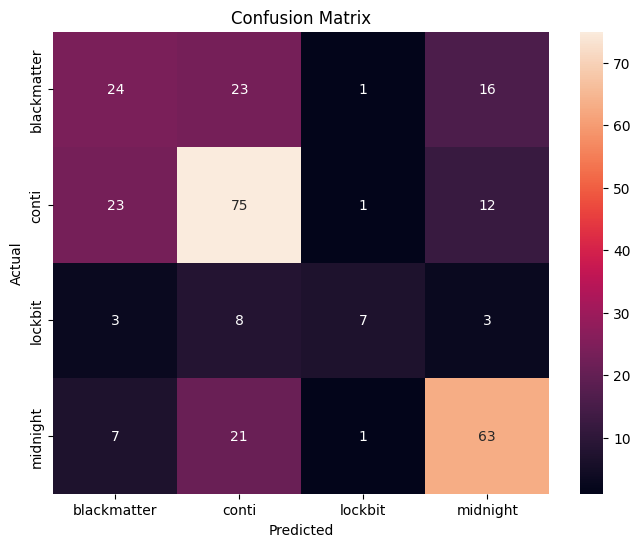

Feature  Importance
4        event_time_span    0.160996
3     event_rate_per_sec    0.146676
1          event_entropy    0.125557
2   longest_repeat_chain    0.117521
0       unique_event_ids    0.075145
26          count_7036.0    0.053373
23          count_5379.0    0.039816
8           count_4672.0    0.037655
5           count_4624.0    0.035825
22          count_5061.0    0.030322

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare X and y
feature_cols = [col for col in df_features_short_term.columns if col not in ['Hash', 'Family']]
X = df_features_short_term[feature_cols]
y = df_features_short_term['Family']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# RandomForest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Top features
feature_importance_df.head(10)


In [48]:
# Your important events list
important_event_ids = [
    4672.0, 4624.0, 5379.0, 5059.0, 5061.0, 5058.0, 4634.0, 4625.0, 4769.0,
    4662.0, 4768.0, 4799.0, 4648.0, 4742.0, 6281.0,
    # (add all the events you listed)
]

# Convert to a set for faster lookup
important_event_ids_set = set(important_event_ids)

def contains_important_event(event_sequence):
    """
    Checks if any event in the sequence is an important event.
    
    Args:
        event_sequence: list of event IDs (as floats or strings)
    
    Returns:
        True if any important event is present, else False
    """
    # Convert all IDs to float (optional if already floats)
    return any(float(event_id) in important_event_ids_set for event_id in event_sequence)


In [48]:
import pandas as pd
import numpy as np

def generate_detection_rules(df_features, model, feature_cols, top_n=5):
    """
    Automatically generate detection rules from feature importance.
    Args:
        df_features: DataFrame with features + labels
        model: Trained ML model (e.g., RandomForest)
        feature_cols: List of feature column names
        top_n: Number of top features to include in rule generation
    Returns:
        List of detection rule dictionaries
    """

    # Get feature importances from the model
    importances = model.feature_importances_

    # Create a DataFrame with features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Get top N features
    top_features = feature_importance_df.head(top_n)

    print(f"Top {top_n} features selected for rule generation:\n")
    print(top_features)

    # Generate rules based on statistical thresholds (e.g., 75th percentile)
    rules = []

    for idx, row in top_features.iterrows():
        feature = row['Feature']
        data = df_features[feature]

        # Compute thresholds (you can choose 75th or 90th percentile)
        threshold_75 = np.percentile(data, 75)

        rule = {
            "feature": feature,
            "threshold": round(threshold_75, 3),
            "condition": "greater than",
            "description": f"If {feature} > {round(threshold_75, 3)}"
        }

        rules.append(rule)

    return rules


In [49]:
def generate_yara_rule(rules, rule_name="Behavioral_Ransomware_Detection_Prototype"):
    """
    Generate a behavioral YARA rule from rule conditions.
    Args:
        rules: List of rule dictionaries (feature, threshold, condition)
        rule_name: Name of the YARA rule
    Returns:
        YARA rule as a string
    """
    conditions = "\n        and ".join(
        [f"{r['feature']} {r['condition'].replace('greater than', '>')} {r['threshold']}" for r in rules]
    )

    yara_rule = f"""
rule {rule_name}
{{
    meta:
        description = "Detects ransomware-like behavior based on Windows Event Log features"
        author = "Your Name"
        date = "2025-03-11"
        family = "Conti / Midnight / BlackMatter / Lockbit"
        type = "behavioral"
    
    condition:
        {conditions}
}}
"""
    return yara_rule


In [50]:
def generate_sigma_rule(rules, title="Behavioral Ransomware Detection", logsource="windows", timeframe="5m"):
    """
    Converts detection rules into a Sigma-style YAML rule.
    Args:
        rules: List of rule dictionaries
        title: Rule title
        logsource: Log source
        timeframe: Time window
    Returns:
        Sigma YAML rule as string
    """
    rule_conditions = "\n".join([f"    - {r['feature']} {r['condition']} {r['threshold']}" for r in rules])

    sigma_rule = f"""
title: {title}
id: auto-generated-rule
description: Automatically generated behavioral detection rule based on ML feature importance.
status: experimental
logsource:
  product: {logsource}
  service: security
detection:
  timeframe: {timeframe}
  condition:
{rule_conditions}
falsepositives:
  - Legitimate high event activity during backups, patching, or administration
level: high
tags:
  - attack.impact
  - attack.t1486
"""
    return sigma_rule


In [51]:
# After training your model and generating df_features_short_term and feature_cols...
rules = generate_detection_rules(df_features_short_term, rf_model, feature_cols, top_n=5)

# Generate YARA Rule
yara_rule_text = generate_yara_rule(rules)
print("YARA Rule:\n")
print(yara_rule_text)

# Generate Sigma Rule
sigma_rule_text = generate_sigma_rule(rules)
print("\nSigma Rule:\n")
print(sigma_rule_text)


Top 5 features selected for rule generation:

                Feature  Importance
3    event_rate_per_sec    0.218461
4       event_time_span    0.216686
1         event_entropy    0.196133
2  longest_repeat_chain    0.162831
0      unique_event_ids    0.108223
YARA Rule:


rule Behavioral_Ransomware_Detection_Prototype
{
    meta:
        description = "Detects ransomware-like behavior based on Windows Event Log features"
        author = "Your Name"
        date = "2025-03-11"
        family = "Conti / Midnight / BlackMatter / Lockbit"
        type = "behavioral"
    
    condition:
        event_rate_per_sec > 0.437
        and event_time_span > 276.0
        and event_entropy > 2.714
        and longest_repeat_chain > 11.0
        and unique_event_ids > 9.0
}


Sigma Rule:


title: Behavioral Ransomware Detection
id: auto-generated-rule
description: Automatically generated behavioral detection rule based on ML feature importance.
status: experimental
logsource:
  product: windows
 